# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


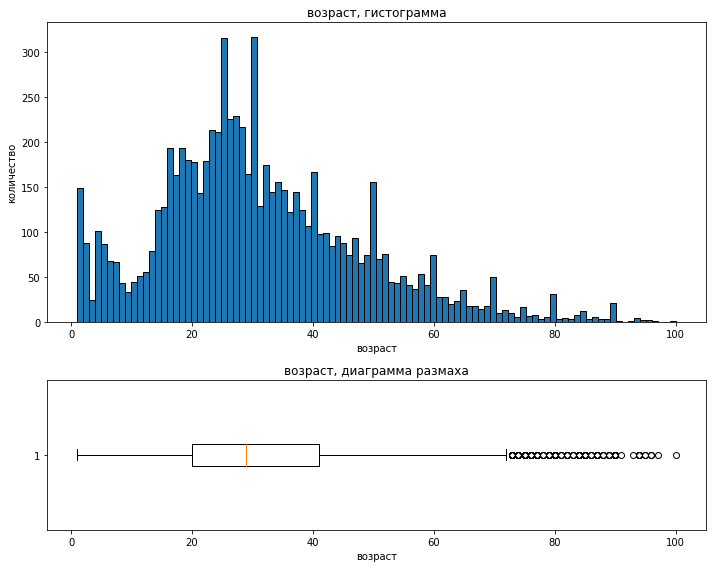

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

ax1.hist(labels['real_age'], bins=100, edgecolor='black')
ax1.set_title('возраст, гистограмма')
ax1.set_xlabel('возраст')
ax1.set_ylabel('количество')

ax2.boxplot(labels['real_age'], vert=False)
ax2.set_title('возраст, диаграмма размаха')
ax2.set_xlabel('возраст')

plt.tight_layout()
plt.show()

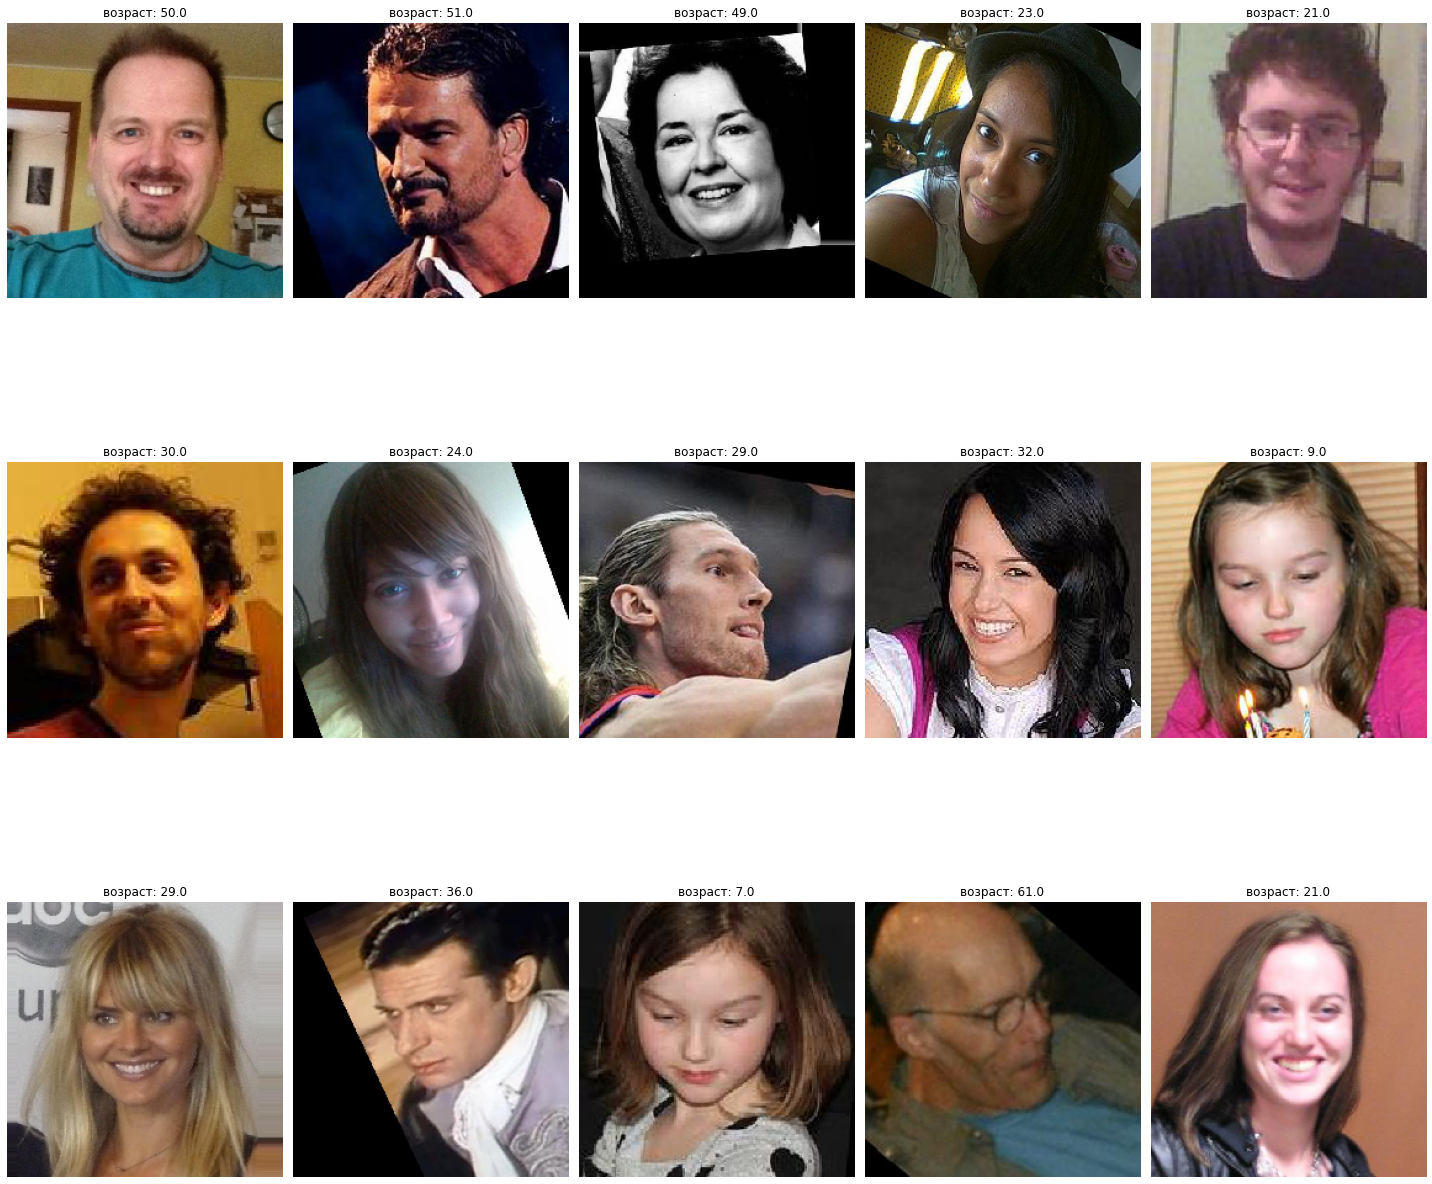

In [4]:
plt.figure(figsize=(20, 20))
for i in range(15):
    plt.subplot(3, 5, i+1)
    batch = next(gen_flow)
    image = batch[0][0]
    age = batch[1][0]
    plt.imshow(image)
    plt.title(f"возраст: {age:.1f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

имеется 7591 обьекта фотографий, в принципе на самом деле для более точной модели можно было и побольше фоток  
минимальный возраст 1, максимальный 100, пик в районе 25-30 лет и порядка 250 фото по каждому году  
с еще локальными пиками в 40 и 50 лет  
из особенностей можем увидеть, что фото очень разные, с разными бекграундами, с разными и необычными ракурсами и разного качества  
по аугментации могу посоветовать точно тильт до 30 количество градусов, добавить блики, доп линии на фото

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.8, 1.))
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 146s - loss: 203.1377 - mae: 10.4117 - val_loss: 717.6717 - val_mae: 21.6989
Epoch 2/10
356/356 - 115s - loss: 99.0582 - mae: 7.5270 - val_loss: 108.5568 - val_mae: 7.8537
Epoch 3/10
356/356 - 125s - loss: 76.8902 - mae: 6.7597 - val_loss: 79.7948 - val_mae: 6.6562
Epoch 4/10
356/356 - 130s - loss: 61.0659 - mae: 5.9591 - val_loss: 96.4530 - val_mae: 7.2785
Epoch 5/10
356/356 - 118s - loss: 53.3332 - mae: 5.6323 - val_loss: 86.5873 - val_mae: 7.0248
Epoch 6/10
356/356 - 126s - loss: 44.0376 - mae: 5.0951 - val_loss: 87.5956 - val_mae: 7.1582
Epoch 7/10
356/356 - 124s - loss: 39.0261 - mae: 4.8402 - val_loss: 79.4011 - val_mae: 6.8416
Epoch 8/10
356/356 - 128s - loss: 32.8420 - mae: 4.4344 - val_loss: 73.8367 - val_mae: 6.3259
Epoch 9/10
356/356 - 125s - loss: 28.0746 - mae: 4.0715 - val_loss: 69.7387 - val_mae: 6.2309
Epoch 10/10
356/356 - 132s - loss: 24.5131 - mae: 3.8464 - val_loss: 81.1102 - val_mae: 6.5626
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 13s - loss: 81.1102 - mae: 6.5626
Test MAE: 6.5626

```

## Анализ обученной модели

для модели использовался бекбон ResNet50 и GlobalAveragePooling2D в качестве головы, последний нейрон активации с функцией ReLU  

модель была уже с предобученная

размер батча был = 16, оптимизатор Adam с lr=0.0001, заморозки весов не произодилось, количество эпох было = 10, функция потерь = mse, метрика = mae  

удалось достигнуть метрики mae на валидационной выборке в районе 6.5, переобучения есть, но небольшое, порядка mae=3  

модель можно использовать как для изначальной задачи  
"Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
Контролировать добросовестность кассиров при продаже алкоголя",  
так и анализа для добросовестности кассиров в других заведениях или местах, где к примеру детский или пенсионный билет могут стоить дешевле, для сбора и анализа продуктовых предпочтений, покупателей разных возрастов